In [ ]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd

# Data preprocessing and visualization
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data downloading and extraction
import zipfile
import io
from urllib.request import urlopen

# Set device for GPU acceleration if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def load_electricity_data():
    """Load and extract the electricity consumption dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
    with urlopen(url) as response:
        with zipfile.ZipFile(io.BytesIO(response.read())) as zip_ref:
            with zip_ref.open('LD2011_2014.txt') as file:
                df = pd.read_csv(file, sep=';', decimal=',',
                               parse_dates=['Unnamed: 0'],
                               index_col='Unnamed: 0')
    return df

# Load and preprocess data
df = load_electricity_data()
df.index = pd.to_datetime(df.index)  # Ensure proper datetime index
df = df.resample('h').mean()  # Convert to hourly data using 'h' instead of 'H'
ts_data = df.iloc[:, 0].values  # Use first consumer's data

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts_data.reshape(-1, 1)).flatten()

In [ ]:
#create time sequence series
def create_sequences(data, seq_length, pred_length):
    """Convert time series into supervised learning format"""
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

seq_length = 168  # 1 week lookback
pred_length = 24   # Predict next 24 hours
X, y = create_sequences(scaled_data, seq_length, pred_length)

# Convert to PyTorch tensors and add channel dimension
X_tensor = torch.FloatTensor(X).unsqueeze(-1)
y_tensor = torch.FloatTensor(y).unsqueeze(-1)

# Train-test split (80-20)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Informer model Implementation
class Informer(nn.Module):
    def __init__(self, input_size=1, output_size=1, seq_len=168, pred_len=24,
                 d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048,
                 dropout=0.05, activation='gelu'):
        super(Informer, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.d_model = d_model

        # Encoder components
        self.enc_embedding = nn.Linear(input_size, d_model)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, n_heads, d_ff, dropout, activation),
            e_layers
        )

        # Decoder components
        self.dec_embedding = nn.Linear(input_size, d_model)
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, n_heads, d_ff, dropout, activation),
            d_layers
        )

        self.projection = nn.Linear(d_model, output_size)

    def forward(self, src, tgt):
        # Encoder processing
        enc_out = self.enc_embedding(src)
        enc_out = self.encoder(enc_out)

        # Decoder processing
        dec_out = self.dec_embedding(tgt)
        dec_out = self.decoder(dec_out, enc_out)

        # Project to output dimension
        return self.projection(dec_out)[:, -self.pred_len:, :]

# Initialize model and move to device
model = Informer().to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Informer(
  (enc_embedding): Linear(in_features=1, out_features=512, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (dec_embedding): Linear(in_features=1, out_features=512, bias=True)
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
    

In [ ]:
#Training Loop
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x, batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print training progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}')

Epoch 1/50, Train Loss: 0.0274
Epoch 2/50, Train Loss: 0.0112
Epoch 3/50, Train Loss: 0.0108
Epoch 4/50, Train Loss: 0.0106
Epoch 5/50, Train Loss: 0.0105
Epoch 6/50, Train Loss: 0.0104
Epoch 7/50, Train Loss: 0.0104
Epoch 8/50, Train Loss: 0.0103
Epoch 9/50, Train Loss: 0.0103
Epoch 10/50, Train Loss: 0.0102
Epoch 11/50, Train Loss: 0.0101
Epoch 12/50, Train Loss: 0.0101
Epoch 13/50, Train Loss: 0.0102
Epoch 14/50, Train Loss: 0.0101
Epoch 15/50, Train Loss: 0.0101
Epoch 16/50, Train Loss: 0.0101
Epoch 17/50, Train Loss: 0.0100
Epoch 18/50, Train Loss: 0.0100
Epoch 19/50, Train Loss: 0.0100
Epoch 20/50, Train Loss: 0.0100
Epoch 21/50, Train Loss: 0.0100
Epoch 22/50, Train Loss: 0.0100
Epoch 23/50, Train Loss: 0.0100
Epoch 24/50, Train Loss: 0.0100
Epoch 25/50, Train Loss: 0.0100
Epoch 26/50, Train Loss: 0.0100
Epoch 27/50, Train Loss: 0.0100
Epoch 28/50, Train Loss: 0.0100
Epoch 29/50, Train Loss: 0.0099
Epoch 30/50, Train Loss: 0.0099
Epoch 31/50, Train Loss: 0.0100
Epoch 32/50, Trai

Test Loss: 0.0104
MAE: 2.0593
MSE: 12.3970


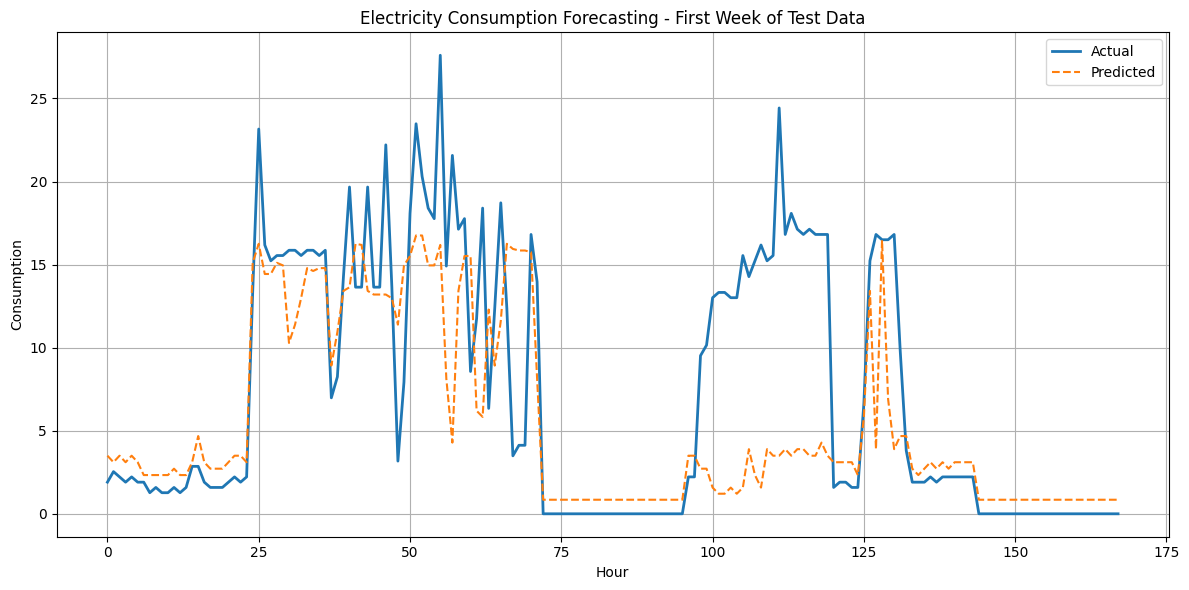

In [ ]:
## Step 5: Evaluation (Memory-Optimized)
model.eval()
test_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Process in smaller chunks if needed
        chunk_size = 8  # Reduce this if you still get OOM errors
        if len(batch_x) > chunk_size:
            outputs = []
            for i in range(0, len(batch_x), chunk_size):
                chunk_x = batch_x[i:i+chunk_size]
                outputs.append(model(chunk_x, chunk_x))
            outputs = torch.cat(outputs, dim=0)
        else:
            outputs = model(batch_x, batch_x)

        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # Store predictions and targets
        all_preds.append(outputs.cpu())
        all_targets.append(batch_y.cpu())

print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Combine all predictions and targets
test_preds = torch.cat(all_preds, dim=0).numpy()
y_true = torch.cat(all_targets, dim=0).numpy()

# Inverse normalization
test_preds = scaler.inverse_transform(test_preds.reshape(-1, 1))
y_true = scaler.inverse_transform(y_true.reshape(-1, 1))

# Calculate metrics
mae = np.mean(np.abs(test_preds - y_true))
mse = np.mean((test_preds - y_true)**2)
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

# Visualization (first week)
plt.figure(figsize=(12, 6))
plt.plot(y_true[:24*7], label='Actual', linewidth=2)
plt.plot(test_preds[:24*7], label='Predicted', linestyle='--')
plt.title('Electricity Consumption Forecasting - First Week of Test Data')
plt.xlabel('Hour')
plt.ylabel('Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()